# Лабораторная работа 1


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, normalize
from sklearn.pipeline import Pipeline
from sklearn.metrics import euclidean_distances, accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Подготовка датасета

In [2]:
data = pd.read_csv('telecom_churn.csv')

In [3]:
data.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [4]:
data.shape

(3333, 11)

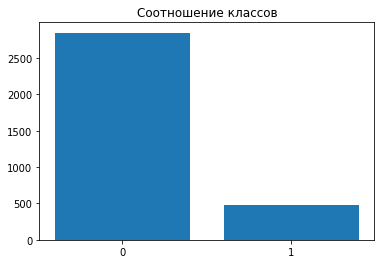

In [5]:
indexes = [0, 1]
cnts = data['Churn'].value_counts().values

plt.title("Соотношение классов")
plt.xticks(indexes)
plt.bar(indexes, cnts)
plt.show()

Для улучшения соотношения сделаем oversampling

In [ ]:
sample = data[data['Churn'] == 1]
while data[data['Churn'] == 1].shape[0] + sample.shape[0] < data[data['Churn'] == 0].shape[0]:
    data = pd.concat([data, sample])
data = pd.concat([data, sample.iloc[:data[data['Churn'] == 0].shape[0] - data[data['Churn'] == 1].shape[0]]])

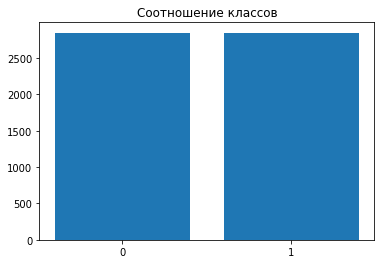

In [ ]:
indexes = [0, 1]
cnts = data['Churn'].value_counts().values

plt.title("Соотношение классов")
plt.xticks(indexes)
plt.bar(indexes, cnts)
plt.show()

In [ ]:
data.shape

(5700, 11)

In [ ]:
X = data.drop('Churn', axis=1).to_numpy()
y = data['Churn'].to_numpy()
print(X.shape)
print(y.shape)

(5700, 10)
(5700,)


Проведем нормализацию признаков:

In [ ]:
X = normalize(X, norm = "max", axis = 0)

Разбиваем на обучающую и тестовую выборки:

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

print("train_X shape: {}".format(train_X.shape))
print("train_Y shape: {}".format(train_y.shape))
print("test_X shape: {}".format(test_X.shape))
print("test_Y shape: {}".format(test_y.shape))

train_X shape: (4560, 10)
train_Y shape: (4560,)
test_X shape: (1140, 10)
test_Y shape: (1140,)


Опишем универсальную функцию score, высчитывающую accuracy, precision и recall:

In [ ]:
def scores(model, data, labels):
    pred_labels = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred_labels))
    print('Precision:', precision_score(labels, pred_labels))
    print('Recall:', recall_score(labels, pred_labels))
    figure = plt.figure(figsize=(20, 5))
    matrix = confusion_matrix(labels, pred_labels)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# SVM

##### Собственный классификатор

In [ ]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        labels = labels * 2 - 1
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                grad = 2 * self.alpha * self.w
                for i, x in enumerate(data_batch):
                    if 1 - x.dot(self.w) * labels_batch[i] > 0:
                        grad -= x * labels_batch[i]
                
                self.w -= self.lr * grad
        return self

    def predict(self, data):
        return (np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) + 1) / 2

In [ ]:
gscv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('svm', SVM())]),
                    {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 5, 10], 
                     'svm__batch': [5, 10, 20], 'svm__alpha': [0.01, 0.001, 0.0001]})
gscv.fit(train_X, train_y)
print(gscv.best_params_, gscv.best_score_, sep = '\n')

{'svm__alpha': 0.01, 'svm__batch': 10, 'svm__epochs': 5, 'svm__lr': 0.001}
0.7671052631578947


Accuracy: 0.7535087719298246
Precision: 0.7531083481349912
Recall: 0.7491166077738516


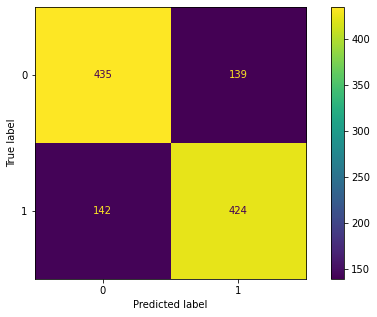

In [ ]:
my_svm = gscv.best_estimator_
scores(my_svm, test_X, test_y)

##### Готовый классификатор

In [ ]:
sklearn_svm = GridSearchCV(Pipeline([('SKL_SVC', SVC())]), {'SKL_SVC__kernel' : ['linear', 'poly']})

sklearn_svm.fit(train_X, train_y)
print(sklearn_svm.best_params_, sklearn_svm.best_score_, sep = '\n')

{'SKL_SVC__kernel': 'poly'}
0.8576754385964913


Accuracy: 0.8456140350877193
Precision: 0.8457446808510638
Recall: 0.842756183745583


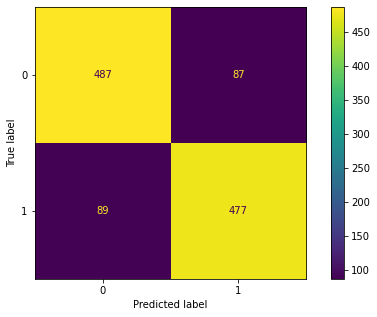

In [ ]:
lib_svm = sklearn_svm.best_estimator_
scores(lib_svm, test_X, test_y)

## KNN

##### Собственный классификатор

In [ ]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k = 1):
        self.k = k
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, x in enumerate(data):
            distances = euclidean_distances([x], self.data)[0]
            neighbors = np.argpartition(distances, kth = self.k - 1)
            k_neighbors = neighbors[:self.k]
            values, counts = np.unique(self.labels[k_neighbors], return_counts = True)
            res[i] = values[counts.argmax()]
        return res

In [ ]:
gscv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNN())]),
                    {'knn__k': [3, 5, 9, 11, 15]})
gscv.fit(train_X, train_y)
print(gscv.best_params_, gscv.best_score_, sep='\n')

{'knn__k': 3}
0.9153508771929824


Accuracy: 0.9245614035087719
Precision: 0.8738317757009346
Recall: 0.991166077738516


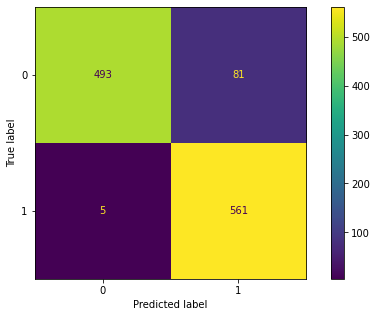

In [ ]:
my_knn = gscv.best_estimator_
scores(my_knn, test_X, test_y)

##### Готовый классификатор

In [ ]:
sklearn_gscv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
                    {'knn__n_neighbors': [3, 5, 9, 11, 15]})
sklearn_gscv.fit(train_X, train_y)
print(sklearn_gscv.best_params_, sklearn_gscv.best_score_, sep='\n')

{'knn__n_neighbors': 3}
0.9153508771929824


Accuracy: 0.9245614035087719
Precision: 0.8738317757009346
Recall: 0.991166077738516


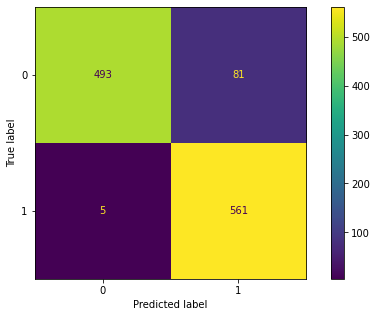

In [ ]:
lib_knn = sklearn_gscv.best_estimator_
scores(lib_knn, test_X, test_y)

## Naive Bayes

##### Собственный классификатор

In [ ]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def normal_gauss(self, x, mu, sigma):
        return (np.exp(-((x - mu) / sigma)**2 / 2)) / np.float32(sigma * np.sqrt(2 * np.pi))

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        labels, counts = np.unique(self.y, return_counts=True)
        self.standard_deviations = np.array([self.X[self.y == label].std(axis=0) for label in labels])
        self.means = np.array([self.X[self.y == label].mean(axis=0) for label in labels])
        self.y_pred = np.array([count / self.y.shape[0] for count in counts])
        self.labels = labels
        return self
         
    def predict(self, X):
        check_is_fitted(self, ['X', 'y'])
        result = np.ndarray(X.shape[0])
        for (num_x, x) in enumerate(X):
            predictions = np.array(self.y_pred)
            for (num_label, label) in enumerate(self.labels):
                predictions[num_label] *= np.prod(np.array([self.normal_gauss(x[i], self.means[num_label][i], self.standard_deviations[num_label][i]) for i in range(X.shape[1])]))
            result[num_x] = np.argmax(predictions)
        return result

Accuracy: 0.8070175438596491
Precision: 0.8276515151515151
Recall: 0.7720848056537103


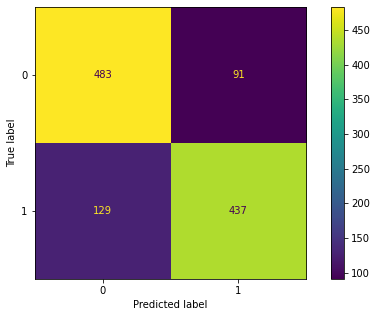

In [ ]:
my_bayes = Pipeline([("NB", NaiveBayes())])
my_bayes.fit(train_X, train_y)
scores(my_bayes, test_X, test_y)

##### Готовый классификатор

Accuracy: 0.8070175438596491
Precision: 0.8276515151515151
Recall: 0.7720848056537103


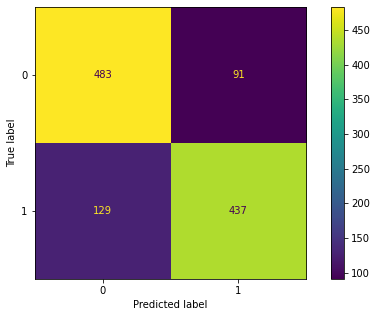

In [ ]:
lib_gnb = GaussianNB()
lib_gnb.fit(train_X, train_y)
scores(lib_gnb, test_X, test_y)

## Logistic Regression

##### Собственный классификатор

In [ ]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')


In [ ]:
gscv = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', LogisticRegression())]),
                    {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [1, 10, 100], 
                     'log__batch': [10, 100, 1000], 'log__alpha': [0.01, 0.001, 0.0001]})
gscv.fit(train_X, train_y)
print(gscv.best_params_, gscv.best_score_, sep='\n')

{'log__alpha': 0.01, 'log__batch': 10, 'log__epochs': 10, 'log__lr': 0.01}
0.7631578947368421


Accuracy: 0.7315789473684211
Precision: 0.7589641434262948
Recall: 0.6731448763250883


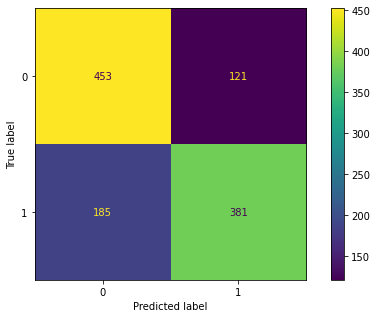

In [ ]:
my_log = gscv.best_estimator_
scores(my_log, test_X, test_y)

##### Готовый классификатор

In [ ]:
gscv = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', SGDClassifier(loss='log', learning_rate='constant'))]),
                    {'log__eta0': [0.1, 0.01, 0.001], 'log__max_iter': [100, 1000, 5000], 
                     'log__alpha': [0.01, 0.001, 0.0001]})
gscv.fit(train_X, train_y)
print(gscv.best_params_, gscv.best_score_, sep='\n')

{'log__alpha': 0.0001, 'log__eta0': 0.001, 'log__max_iter': 100}
0.7605263157894737


Accuracy: 0.7359649122807017
Precision: 0.7886710239651417
Recall: 0.6395759717314488


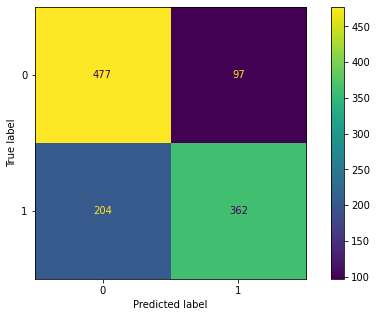

In [ ]:
lib_reg = gscv.best_estimator_
scores(lib_reg, test_X, test_y)